# Econ 213R Project
### Isobel Sorenson and Bryce Bangerter

For our project, we collected data from the CIA's World Factbook, which is a dataset of all the countries in the world with their respective economic, demographic, and geographic data. We wanted to create a model that could analyze and interpret this data and predict what continent a country belonged to based on the economic, demographic, and geographic data for the country. We figured that this might be useful in seeing how well a model can predict a country's continent based on these data because it may show us that there are difficulties in classification because of disparities between countries in the same continent. For example, we would expect it to be difficult for the model to distiguish between countries that are classified as Oceania from countries in the Caribbean and Virgin Islands which are classified as North America. Another example would be Eastern vs. Western Europe. The model may give us insights into inequality across countries within continents and show us possible ways to classify or distinguish areas of the world better than the traditional continental classification system. We used a boosting model for classification as well as t-SNE to reduce the dimensionality for viewing purposes.

The following sections will cover:
1. Data Cleaning and Feature Engineering
2. K-Nearest Neighbors 
3. Random Forest
4. Boosting
5. t-SNE
6. Conclusion

## Data Cleaning and Feature Engineering

In this section, we will cover an essential first step before running any models on the data. This step is referred to as data cleaning and feature engineering. What we will do here is fill missing values, drop variables we don't need, create new variables that are some transformation/combination of the other variables, and change values to be in a usable and interpretable format. 

First, we import all the packages that we will need for reading and cleaning our data, as well as for running the models afterwards. Then, we add a variable 'contnum' that assigns each continent a number, which turns our target labels into numeric, rather than string data (essential for doing the Random Forest model later on).

In [1]:
#import packages from scikitlearn for modeling
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
import missingno as msno
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import pprint
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline

/Users/brycebangerter/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brycebangerter/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#read in dataset
fulldf= pd.read_csv("/Users/brycebangerter/Documents/project1.csv")
df = pd.read_csv("/Users/brycebangerter/Documents/project1.csv")

In [3]:
#code to make new variable that assigns each continent a numeric value
df['contnum'] = df['cont'].copy()
df['contnum'].replace('Asia', 1, inplace=True)
df['contnum'].replace('Africa', 2, inplace=True)
df['contnum'].replace('Europe', 3, inplace=True)
df['contnum'].replace('North America', 4, inplace=True)
df['contnum'].replace('Oceania', 5, inplace=True)
df['contnum'].replace('South America', 6, inplace=True)

cont_key = ['Asia', 'Africa', 'Europe', 'North America', 'Oceania', 'South America']
cont_sr = pd.Series(cont_key).astype(str)

In our dataset, there are values that have characters like commas, dollar signs, and percentage symbols, likely as a result of how they were orginally entered into the dataset. We can remove these symbols and change the value type from string to float so that we can treat these variables as numbers, not strings. 

In [4]:
#remove characters in the values for variables that should be numeric
df=df.replace(',', '' , regex=True)
df=df.replace('%', '' , regex=True)
df['GDP_PPP_percapita']=df['GDP_PPP_percapita'].str.replace('$', '')

In [5]:
#convert data type to float
df.loc[:, 'Pop2013':'Percent Urban']= df.loc[:, 'Pop2013':'Percent Urban'].astype(float)

Next, we do something called feature engineering, which is where we create a new variable from existing variables. We want to make two new variables that may be important and helpful for the model to classify countries. We created a 'PopDens' variable which measures the population density of a country, which is the total population divided by the land area of the country, represented in square kilometers. Another variable we created was 'Coast_Area_Ratio' which measures the ratio of coastline to a country's land area, which we calculate by taking the coastline the country possesses(measured in kilometers) divided by the land area of the country (measured in square kilometers). Both of these variables will be helpful in classifying countries to their respective continents.

I also rename two of the columns so that there aren't any spaces between words, as this sometimes causes issues later with syntax.

In [6]:
#create new feature
df['PopDens']= df['Pop2013']/df['Area_sqkm']

In [7]:
#create new feature
df['Coast_Area_Ratio'] = df['coastline_km'] / df['Area_sqkm']

In [8]:
#rename column to have no spaces
df.rename(columns={'GDP PPP': 'GDP_PPP'}, inplace=True)
df.rename(columns={'Percent Urban': 'Percent_Urban'}, inplace=True)

In [9]:
#check to see if all variables are the right data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 23 columns):
cont                     223 non-null object
name                     223 non-null object
Pop2013                  223 non-null float64
Area_sqkm                223 non-null float64
coastline_km             223 non-null float64
PopGrowthRate            223 non-null float64
BirthRate                223 non-null float64
DeathRate                223 non-null float64
NetMigrationRate         220 non-null float64
MaternalMortalityRate    183 non-null float64
IMR                      222 non-null float64
LifeExpectancy           222 non-null float64
TotalFertilityRate       222 non-null float64
AdultObesityRate         190 non-null float64
HealthExpend             190 non-null float64
ChildUnderwt             132 non-null float64
ChildUnderwtYr           132 non-null float64
GDP_PPP                  223 non-null float64
GDP_PPP_percapita        223 non-null float64
Percent_Urban          

Our type of data looks good, so the next step is to see what variables are missing data and how many missing values they have. We then need to decide whether to drop these variables because of the missing data, or impute values for the missing data. First, let's take a look at what variables we're missing data for and how much is missing.

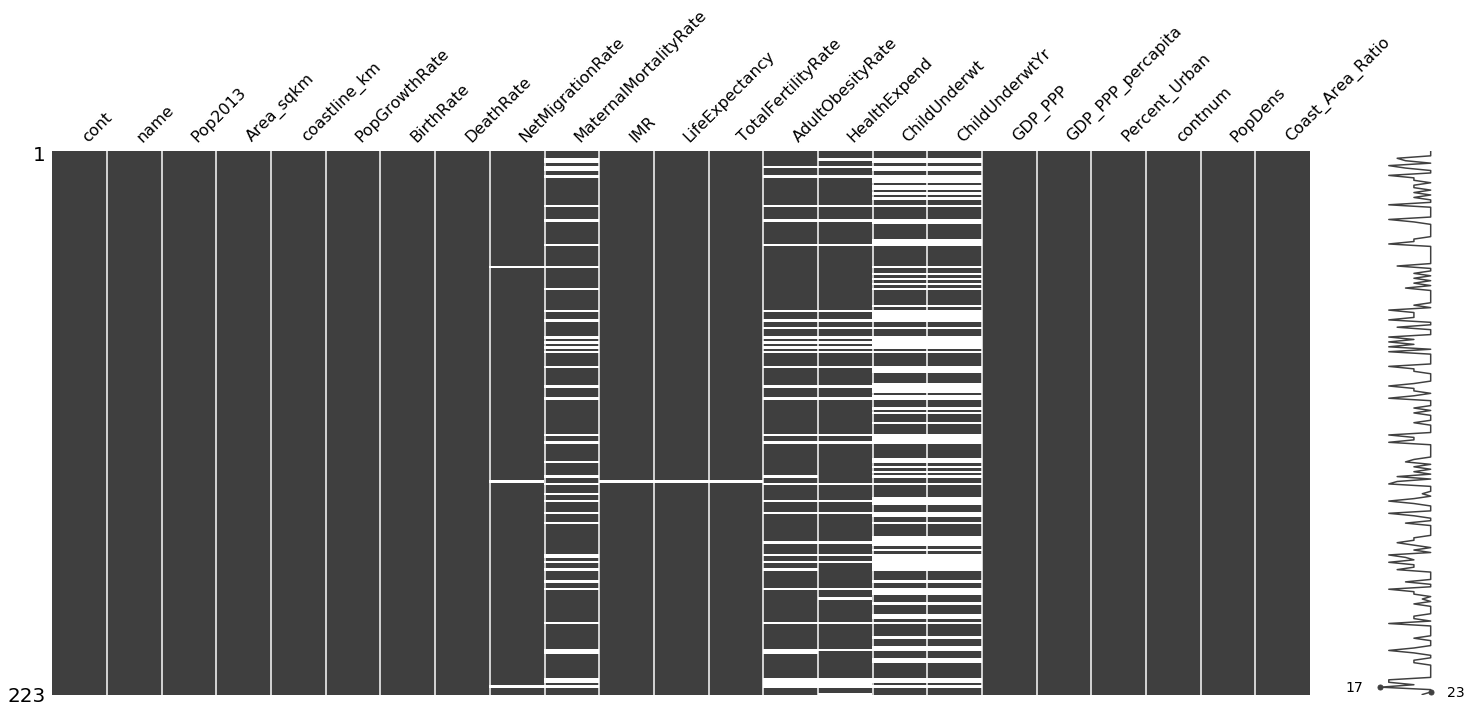

In [10]:
#create matrix that shows missing data by highlighting it with white
msno.matrix(df)

In [11]:
#shows how many missng values we have for each variable
df.isnull().sum()

cont                      0
name                      0
Pop2013                   0
Area_sqkm                 0
coastline_km              0
PopGrowthRate             0
BirthRate                 0
DeathRate                 0
NetMigrationRate          3
MaternalMortalityRate    40
IMR                       1
LifeExpectancy            1
TotalFertilityRate        1
AdultObesityRate         33
HealthExpend             33
ChildUnderwt             91
ChildUnderwtYr           91
GDP_PPP                   0
GDP_PPP_percapita         0
Percent_Urban             0
contnum                   0
PopDens                   0
Coast_Area_Ratio          0
dtype: int64

We can see that we are missing data for 11 variables. Because the 'ChildUnderwt' and 'ChildUnderwtYr' variables have so many missing values (41.7% of countries are missing data for these variables) we just dropped them since they wouldn't be very informative. For the rest of the variables with missing data, we imputed the median value for that variable for the missing values for that variable. Using the median is a good value to impute with because we would expect, on average, for a country to have the average value of any variable, and using a median works better than the mean because means are susceptible to being skewed left or right by outliers. We define this function to impute for missing values below.

In [12]:
#drop these variables
df.drop(columns = 'ChildUnderwt', inplace=True)
df.drop(columns = 'ChildUnderwtYr', inplace=True)

In [13]:
#define a function to fill missing values with median of existing values for each variable
def mynafill(var):
    df[var].fillna((df[var].median()), inplace=True)

In [14]:
#perform function defined above
mynafill("MaternalMortalityRate")
mynafill("NetMigrationRate")
mynafill("IMR")
mynafill("LifeExpectancy")
mynafill("TotalFertilityRate")
mynafill("AdultObesityRate")
mynafill("HealthExpend")
mynafill("GDP_PPP")
mynafill("Percent_Urban")

We can see below that there are no more missing data anymore. Another thing we must do before we can proceed with modeling is to put all the variables into proper scales - in this case, decimals. Some of the variables are recorded as percentages, some as number of births per 1000 people, and so on. To make everything common and comparable, I divided these variables by their respective scales, as described in the CIA Factbook in their description of what each variable represents.

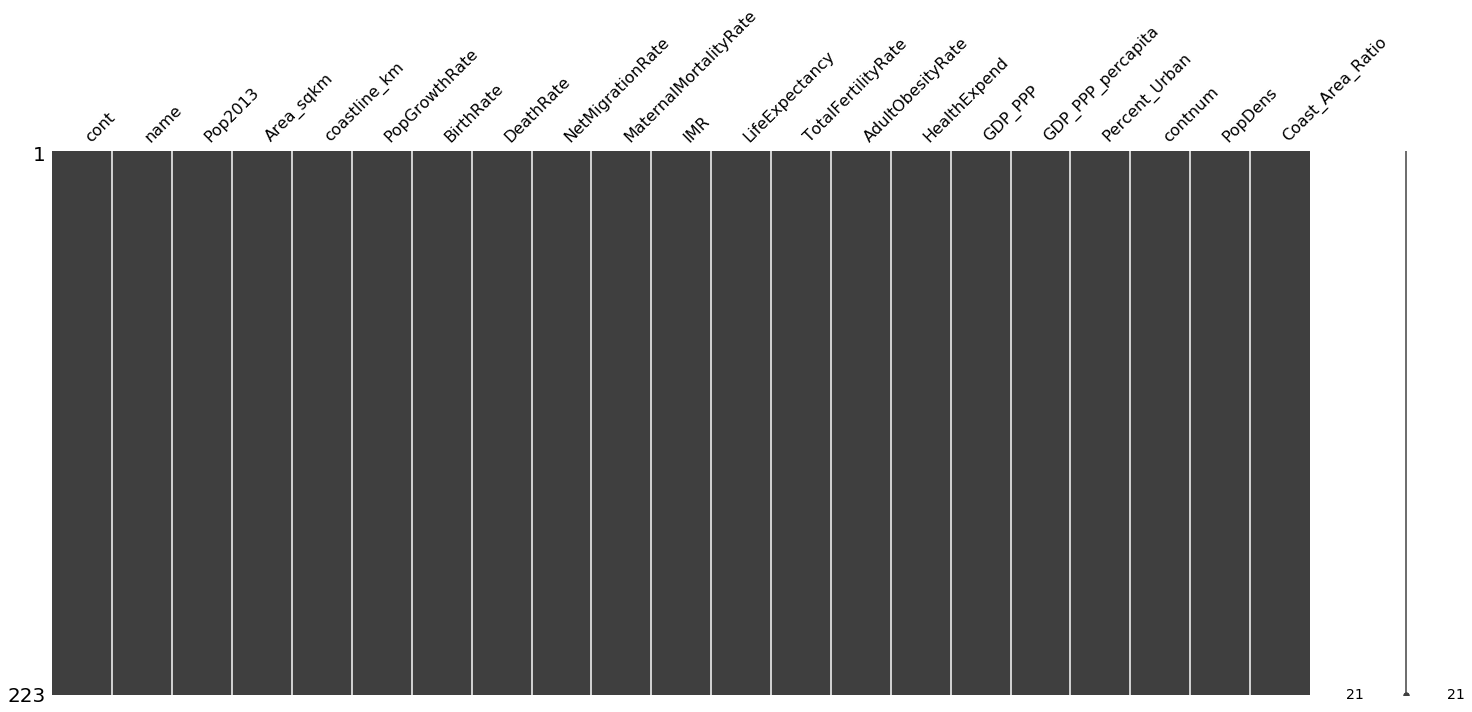

In [15]:
#look at matrix again to see that there are no missing values
msno.matrix(df)

In [16]:
#convert to decimal form
df['Percent_Urban'] = df['Percent_Urban'] / 100
df['BirthRate'] = df['BirthRate'] / 1000
df['DeathRate'] = df['DeathRate'] / 1000
df['PopGrowthRate'] = df['PopGrowthRate'] / 100
df['IMR'] = df['IMR'] / 1000
df['NetMigrationRate'] = df['NetMigrationRate'] / 1000
df['MaternalMortalityRate'] = df['MaternalMortalityRate'] / 100000
df['AdultObesityRate'] = df['AdultObesityRate'] / 100
df['HealthExpend'] = df['HealthExpend'] / 100

## Modeling

With the cleaning all done, we can now split the dataframe, separating our label and target columns from the features. For our target feature, we are using the numerically differentiated continent labels- this is essential for the random forest model. Afterwords, we check to make sure it all looks good.

In [17]:
Y=df['contnum']
cont=df['cont']
name=df['name']
X=df.drop(['cont', 'name', 'contnum'], axis=1)

In [18]:
print(np.unique(Y))

[1 2 3 4 5 6]


In [19]:
X.tail()

,Pop2013,Area_sqkm,coastline_km,PopGrowthRate,BirthRate,DeathRate,NetMigrationRate,MaternalMortalityRate,IMR,LifeExpectancy,TotalFertilityRate,AdultObesityRate,HealthExpend,GDP_PPP,GDP_PPP_percapita,Percent_Urban,PopDens,Coast_Area_Ratio
218,2676740.0,5860.0,0.0,0.0203,0.02381,0.00353,0.00000,0.00064,0.01398,75.46,2.91,0.1995,0.066,8.022000e+09,2900.0,0.743,456.781570,0.000000
219,538811.0,266000.0,1110.0,0.0296,0.03118,0.00864,-0.00006,0.00066,0.05750,61.90,4.15,0.1995,0.066,9.065000e+08,2500.0,0.820,2.025605,0.004173
220,25408288.0,527968.0,1906.0,0.0250,0.03163,0.00664,0.00000,0.00200,0.05193,64.47,4.27,0.1450,0.052,6.006000e+10,2300.0,0.323,48.124674,0.003610
221,14222233.0,752618.0,0.0,0.0289,0.04279,0.01317,-0.00075,0.00440,0.06858,51.51,5.81,0.0360,0.059,2.436000e+10,1700.0,0.392,18.897014,0.000000
222,13182908.0,390757.0,0.0,0.0438,0.03241,0.01140,0.02276,0.00570,0.02725,53.86,3.58,0.0700,0.066,7.366000e+09,600.0,0.386,33.736844,0.000000


We also define a function that will plot confusion matrices of our prediction accuracies for more intuitive visualization.  We do so below.

In [20]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.matshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## KNearestNeighbors Classifier

After splitting our data into training and testing data, we use GridSearch to evaluate which parameters produce the most accurate model.  Our analysis suggests that we should have 5 neighbors, a p value of 1, and uniform weights.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=18)
clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7,], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]})
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_, average=None))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Train F1: [0.54901961 0.56637168 0.52631579 0.33333333 0.54545455 0.        ]
Test Classification Report:
             precision    recall  f1-score   support

          1       0.38      0.33      0.35         9
          2       0.33      0.38      0.35         8
          3       0.36      0.50      0.42         8
          4       0.50      0.17      0.25         6
          5       0.25      0.50      0.33         2
          6       0.00      0.00      0.00         1

avg / total       0.37      0.35      0.34        34

Train Accuracy: 0.5079365079365079	Test accuracy: 0.35294117647058826


Confusion matrix, without normalization
[[3 2 4 0 0 0]
 [2 3 1 1 1 0]
 [3 1 4 0 0 0]
 [0 2 1 1 2 0]
 [0 0 1 0 1 0]
 [0 1 0 0 0 0]]


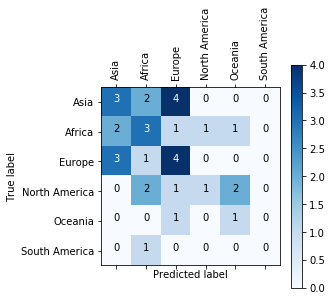

In [22]:
#Plotting the confusion matrix for this model
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cont_key,)
plt.show()

Even applying the suggested parameters in the model above, from the classification report right out of the gate we can see that our knn model is not performing very well. Even the training accuracy isn't very good, and the 35% accuracy on the testing data is abysmal.

We wondered if the model would work better if we simplified the data a bit- turning a few of the continuous features into a score of relative advantage. Below, we do just that.

We generate quintile categorizations for Infant Mortality Rates, Health Expenditures, Life Expectancy, and GDP per capita.  We make the IMR quintile negative as a way of scaling it to represent disadvantage in a way comparable to the other three, and then sum these 4 ordinal variables to create a score of advantage.  Given our parameters, the scores can range from -2 to 14.  

In [23]:
X_score=X.copy()

In [24]:
#defining a function that will produce ordinally ranked quintiles of our continuous data.
def quintiles(var):
    X_score[var+'q'] = pd.qcut(X_score[var] ,5, labels=[1,2,3,4,5]).astype(float)

In [25]:
quintiles('IMR')
quintiles('HealthExpend')
quintiles('LifeExpectancy')
quintiles('GDP_PPP_percapita')

In [26]:
X_score['IMRq']*=-1
X_score['advantage_score'] = X_score.loc[:, 'IMRq':'GDP_PPP_percapitaq'].sum(axis=1)

In [27]:
X_score.drop(columns = 'IMR', inplace=True)
X_score.drop(columns = 'HealthExpend', inplace=True)
X_score.drop(columns = 'LifeExpectancy', inplace=True)
X_score.drop(columns = 'GDP_PPP_percapita', inplace=True)

In [28]:
X_score.drop(columns = 'IMRq', inplace=True)
X_score.drop(columns = 'HealthExpendq', inplace=True)
X_score.drop(columns = 'LifeExpectancyq', inplace=True)
X_score.drop(columns = 'GDP_PPP_percapitaq', inplace=True)

In [29]:
X_score.head()

,Pop2013,Area_sqkm,coastline_km,PopGrowthRate,BirthRate,DeathRate,NetMigrationRate,MaternalMortalityRate,TotalFertilityRate,AdultObesityRate,GDP_PPP,Percent_Urban,PopDens,Coast_Area_Ratio,advantage_score
0,31108077.0,652230.0,0.0,0.0225,0.03905,0.01435,-0.00216,0.00460,5.54,0.022,3.429000e+10,0.235,47.694950,0.000000,1.0
1,3011405.0,28748.0,362.0,0.0029,0.01257,0.00636,-0.00332,0.00027,1.49,0.213,2.654000e+10,0.520,104.751809,0.012592,7.0
2,38087812.0,2381741.0,998.0,0.0190,0.02425,0.00431,-0.00093,0.00097,2.78,0.160,2.774000e+11,0.730,15.991584,0.000419,3.0
3,54719.0,199.0,116.0,-0.0040,0.02284,0.00462,-0.02217,0.00066,3.04,0.746,5.753000e+08,0.930,274.969849,0.582915,7.0
4,85293.0,468.0,0.0,0.0022,0.00888,0.00667,0.00000,0.00066,1.37,0.252,3.163000e+09,0.880,182.250000,0.000000,13.0


With our advantage score ready to go and the features that contribute to it dropped from the feature list, we are ready to predict parameters on the new set of data and run the tuned-up model. 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_score, Y, test_size=0.15, random_state=18)
clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7,], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]})
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_, average=None))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train, average=None)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Train F1: [0.55 0.57 0.53 0.33 0.55 0.  ]
Test Classification Report:
             precision    recall  f1-score   support

          1       0.38      0.33      0.35         9
          2       0.33      0.38      0.35         8
          3       0.36      0.50      0.42         8
          4       0.50      0.17      0.25         6
          5       0.25      0.50      0.33         2
          6       0.00      0.00      0.00         1

avg / total       0.37      0.35      0.34        34

Train Accuracy: 0.5079365079365079	Test accuracy: 0.35294117647058826


The suggested parameters remained the same as the first model. Unfortunately, this feature engineering had no effect on the accuracy of our model. Instead, we turn to an entirely new model.

## Random Forest Classifier

We decided to try our random forest model on two different sets of the data.

The first model we feed the same dataframe as the last knn model- the set that includes the score of advantage.

For the second model, knowing that decision trees should theoretically work best on categorical data, we run the model on a dataset in which we have reduced all of our features into binned categorical quintiles.

Immediately below we create that categorical data.

In [31]:
#X_cat is going to be our categorical dataset
X_cat=X.copy()

In [32]:
#tweaking our quintile function
def quintiles(var):
    X_cat[var+'q'] = pd.qcut(X_cat[var] ,5, labels=[1,2,3,4,5]).astype(float)

In [33]:
quintiles('Pop2013')
quintiles('Area_sqkm')
quintiles('coastline_km')
quintiles('PopGrowthRate')
quintiles('BirthRate')
quintiles('DeathRate')
quintiles('NetMigrationRate')
quintiles('MaternalMortalityRate')
quintiles('TotalFertilityRate')
quintiles('AdultObesityRate')
quintiles('GDP_PPP')
quintiles('Percent_Urban')
quintiles('PopDens')
quintiles('Coast_Area_Ratio')
quintiles('IMR')
quintiles('HealthExpend')
quintiles('LifeExpectancy')
quintiles('GDP_PPP_percapita')

In [34]:
X_cat.drop(columns = X_cat.loc[:, 'Pop2013':'Coast_Area_Ratio'], inplace=True)

In [35]:
X_cat.head()

,Pop2013q,Area_sqkmq,coastline_kmq,PopGrowthRateq,BirthRateq,DeathRateq,NetMigrationRateq,MaternalMortalityRateq,TotalFertilityRateq,AdultObesityRateq,GDP_PPPq,Percent_Urbanq,PopDensq,Coast_Area_Ratioq,IMRq,HealthExpendq,LifeExpectancyq,GDP_PPP_percapitaq
0,5.0,5.0,1.0,5.0,5.0,5.0,2.0,5.0,5.0,1.0,3.0,1.0,2.0,1.0,5.0,4.0,1.0,1.0
1,2.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0
2,5.0,5.0,4.0,4.0,4.0,1.0,2.0,4.0,4.0,2.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,1.0,1.0,2.0,1.0,4.0,1.0,1.0,3.0,4.0,5.0,1.0,5.0,5.0,5.0,2.0,3.0,3.0,3.0
4,1.0,1.0,1.0,2.0,1.0,2.0,3.0,3.0,1.0,4.0,2.0,5.0,4.0,1.0,1.0,4.0,5.0,5.0


With both sets of data ready to go, we begin training our model.  Using train test split (and a handy method of finding the best f1 score that was modeled in Tyler's lecture) we evaluate the best parameters for our model. 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_score, Y, test_size=0.15, random_state=18)

n_estimators = [1000, 750, 500]
max_depth = [5, 10, 15]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            rf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            rf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(rf.oob_decision_function_ , 1), average='micro')
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
1000 15 balanced
1000 15 None
750 5 balanced
750 5 None
750 10 balanced
750 10 None
750 15 balanced
750 15 None
500 5 balanced
500 5 None
500 10 balanced
500 10 None
500 15 balanced
500 15 None


In [37]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.06878306878306878
Best params: (500, 5, 'balanced')


Using the parameters suggested by our analysis, we find that our model is remarkably accurate on the training data, classifying over 90% of the data correctly.  Given the confusion we expected over regions such as Oceania and the Carribean, this is somewhat exciting.

In [38]:
rf = RandomForestClassifier(n_estimators=750, max_depth=5, class_weight='balanced')
rf.fit(X_train, y_train)
train_predictions5 = rf.predict(X_train)
print(classification_report(y_train, train_predictions5))

             precision    recall  f1-score   support

          1       0.95      0.98      0.97        43
          2       1.00      0.87      0.93        47
          3       0.97      0.95      0.96        40
          4       0.85      1.00      0.92        28
          5       1.00      1.00      1.00        19
          6       0.92      1.00      0.96        12

avg / total       0.96      0.95      0.95       189



In [39]:
rf = RandomForestClassifier(n_estimators=750, max_depth=5, class_weight='balanced')
rf.fit(X_train, y_train)
test_pred1 = rf.predict(X_test)
print(classification_report(y_test, test_pred1))

             precision    recall  f1-score   support

          1       0.86      0.67      0.75         9
          2       0.86      0.75      0.80         8
          3       0.89      1.00      0.94         8
          4       0.57      0.67      0.62         6
          5       1.00      1.00      1.00         2
          6       0.00      0.00      0.00         1

avg / total       0.80      0.76      0.78        34



Confusion matrix, without normalization
[[5 2 0 1 0 1]
 [0 6 0 1 0 1]
 [0 0 8 0 0 0]
 [1 0 1 4 0 0]
 [0 0 0 0 2 0]
 [0 0 0 1 0 0]]


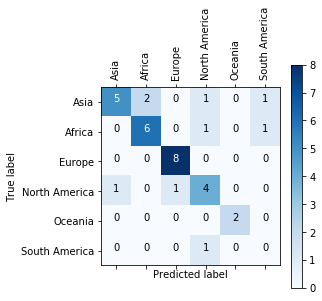

In [40]:
#Plotting the confusion matrix for this model
y_pred = rf.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cont_key,)
plt.show()

Using our trained model on our test set, we see that accuracy drops almost 20%, but compared to our knn models dismal performance, and in light of the geographic confusion we noted expecting, having nearly 80% accuracy is fantastic. 

In [41]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/brycebangerter/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

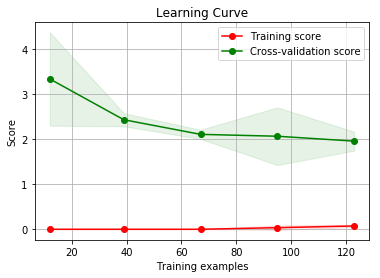

In [42]:
plot_learning_curve(rf, "Learning Curve", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/brycebangerter/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

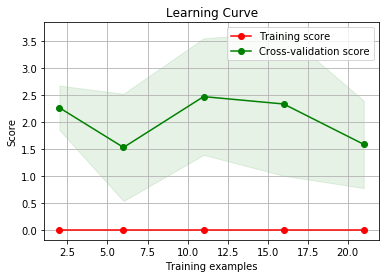

In [43]:
plot_learning_curve(rf, "Learning Curve", X_test, y_test)

Alright, we've run our first model with the more normal data set, and from the looks of our accuracy as well as the MSE visualed above by our learning curve, it looks like we're doing pretty well. An MSE of 1.5 ish is not too bad in the context of our model.  Both the training and testing learning curves look pretty good. (The second graph is the test graph). 

Now we'll see how the categorical version of the data runs in the model.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, Y, test_size=0.15, random_state=18)

n_estimators = [1000, 750, 500]
max_depth = [5, 10, 15]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            rf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            rf.fit(X_train, y_train)
            f1 = f1_score(y_train, np.argmax(rf.oob_decision_function_ , 1), average='micro')
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
1000 15 balanced
1000 15 None
750 5 balanced
750 5 None
750 10 balanced
750 10 None
750 15 balanced
750 15 None
500 5 balanced
500 5 None
500 10 balanced
500 10 None
500 15 balanced
500 15 None


In [45]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.06349206349206349
Best params: (1000, 5, 'balanced')


Using the parameters suggested by our analysis above, we run our model on the training data and can already see a slight decrease in accuracy compared to the previous model.

In [46]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced')
rf.fit(X_train, y_train)
train_predictions5 = rf.predict(X_train)
print(classification_report(y_train, train_predictions5))

             precision    recall  f1-score   support

          1       0.84      0.88      0.86        43
          2       1.00      0.85      0.92        47
          3       0.93      0.95      0.94        40
          4       0.89      0.89      0.89        28
          5       1.00      0.95      0.97        19
          6       0.71      1.00      0.83        12

avg / total       0.91      0.90      0.91       189



In [47]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced')
rf.fit(X_train, y_train)
test_pred1 = rf.predict(X_test)
print(classification_report(y_test, test_pred1))

             precision    recall  f1-score   support

          1       0.86      0.67      0.75         9
          2       0.86      0.75      0.80         8
          3       1.00      1.00      1.00         8
          4       0.56      0.83      0.67         6
          5       1.00      0.50      0.67         2
          6       0.00      0.00      0.00         1

avg / total       0.82      0.76      0.78        34



Looking at the accuracy of the model on the testing data, we also see a small decrease from the first random forest model. 

In [48]:
f1_score(y_train, train_predictions5, average = 'macro')

0.9024774201977267

Turns out the all categorical data set performed worse in the random forest model, despite our theoretical idea that it would be easier for the model to process and classify. This is an interesting, unexpected finding.  
But in better news, we're happy with the performance of the first model!

## Boosting

Boosting is another ensemble techinque like random forests, but boosting trains multiple models/trees sequentially where each each model/tree tries to improve on the areas where the previous models/trees performed poorly. It slowly learns and penalizes misclassifications by weighting them more heavily until the final model/tree does the best job of predicting classifications for each observation. Boosting has the tendency to overfit, but this isn't something we worry about happening because we have a data set that includes the entire population. 

Below, we run the boosting model and measure its accuracy through an f1 score, which is a metric that measures how well the model does at precision and recall, balancing the two. 

In [49]:
#view the first 5 rows of data
df.head()

,cont,name,Pop2013,Area_sqkm,coastline_km,PopGrowthRate,BirthRate,DeathRate,NetMigrationRate,MaternalMortalityRate,...,LifeExpectancy,TotalFertilityRate,AdultObesityRate,HealthExpend,GDP_PPP,GDP_PPP_percapita,Percent_Urban,contnum,PopDens,Coast_Area_Ratio
0,Asia,Afghanistan,31108077.0,652230.0,0.0,0.0225,0.03905,0.01435,-0.00216,0.00460,...,50.11,5.54,0.022,0.076,3.429000e+10,1100.0,0.235,1,47.694950,0.000000
1,Europe,Albania,3011405.0,28748.0,362.0,0.0029,0.01257,0.00636,-0.00332,0.00027,...,77.77,1.49,0.213,0.066,2.654000e+10,8200.0,0.520,3,104.751809,0.012592
2,Africa,Algeria,38087812.0,2381741.0,998.0,0.0190,0.02425,0.00431,-0.00093,0.00097,...,76.18,2.78,0.160,0.042,2.774000e+11,7600.0,0.730,2,15.991584,0.000419
3,Oceania,American Samoa,54719.0,199.0,116.0,-0.0040,0.02284,0.00462,-0.02217,0.00066,...,74.68,3.04,0.746,0.066,5.753000e+08,8000.0,0.930,5,274.969849,0.582915
4,Europe,Andorra,85293.0,468.0,0.0,0.0022,0.00888,0.00667,0.00000,0.00066,...,82.58,1.37,0.252,0.075,3.163000e+09,37200.0,0.880,3,182.250000,0.000000


In [50]:
#create new data frame that doesn't have the classification variables
df1 = df.drop(['cont', 'name', 'contnum'], axis=1)

In [51]:
#Break up dataset into train and test subsets for training and testing the model
X_train, X_test, y_train, y_test = train_test_split(df1, df.cont, test_size=0.20, random_state=42)

In [52]:
#view the first 5 rows of training data
X_train.head()

,Pop2013,Area_sqkm,coastline_km,PopGrowthRate,BirthRate,DeathRate,NetMigrationRate,MaternalMortalityRate,IMR,LifeExpectancy,TotalFertilityRate,AdultObesityRate,HealthExpend,GDP_PPP,GDP_PPP_percapita,Percent_Urban,PopDens,Coast_Area_Ratio
127,69747.0,181.0,370.0,0.0179,0.02721,0.00427,-0.00500,0.00066,0.02215,72.31,3.29,0.4540,0.181,4.818000e+08,8800.0,0.720,385.342541,2.044199
66,896758.0,18274.0,1129.0,0.0073,0.02028,0.00596,-0.00699,0.00026,0.01046,71.87,2.54,0.3060,0.049,4.373000e+09,4900.0,0.520,49.072890,0.061782
73,4555911.0,69700.0,310.0,-0.0033,0.01072,0.01017,-0.00386,0.00067,0.01421,77.51,1.46,0.2210,0.101,2.711000e+10,6000.0,0.528,65.364577,0.004448
96,86159.0,572.0,160.0,0.0084,0.01127,0.00999,0.00711,0.00066,0.00422,80.87,1.95,0.1995,0.066,4.076000e+09,53800.0,0.510,150.627622,0.279720
119,583003.0,28.0,41.0,0.0085,0.00903,0.00397,0.00343,0.00066,0.00315,84.46,0.93,0.1995,0.066,4.719000e+10,82400.0,1.000,20821.535714,1.464286


In [53]:
#define the gradient boosting model
clf = GradientBoostingClassifier()

In [54]:
#create a cross-validation function that will find optimal hyperparameters for boosting model
gridsearch = GridSearchCV(clf, {"learning_rate": [.1, .01, .001], "n_estimators": [100, 1000, 5000], 
                                'max_depth': [1, 2, 3]}, scoring='f1_micro')

In [55]:
#fit the model to the training data
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 1000, 5000], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_micro', verbose=0)

In [56]:
#print the best parameters found from cross-validation and the results of the model for train and test subsets
print("Best Params: {}".format(gridsearch.best_params_))
print("\nClassification Report (TEST):")
print(classification_report(y_test, gridsearch.predict(X_test)))
print("\nClassification Report (TRAIN):")
print(classification_report(y_train, gridsearch.predict(X_train)))

Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}

Classification Report (TEST):
               precision    recall  f1-score   support

       Africa       0.92      0.85      0.88        13
         Asia       0.71      0.62      0.67         8
       Europe       0.76      0.87      0.81        15
North America       0.25      1.00      0.40         2
      Oceania       1.00      0.20      0.33         5
South America       0.00      0.00      0.00         2

  avg / total       0.77      0.71      0.70        45


Classification Report (TRAIN):
               precision    recall  f1-score   support

       Africa       0.97      0.93      0.95        42
         Asia       0.98      0.98      0.98        44
       Europe       0.97      0.97      0.97        33
North America       0.89      0.97      0.93        32
      Oceania       1.00      0.94      0.97        16
South America       1.00      1.00      1.00        11

  avg / total       0.96      0.96

In [57]:
#see how many of each continent are in the dataset
y_train.value_counts()

Asia             44
Africa           42
Europe           33
North America    32
Oceania          16
South America    11
Name: cont, dtype: int64

Confusion matrix, without normalization
[[10  1  0  2  0  0]
 [ 1  5  2  0  0  0]
 [ 0  0 13  2  0  0]
 [ 0  1  0  1  0  0]
 [ 0  0  2  2  1  0]
 [ 0  1  1  0  0  0]]


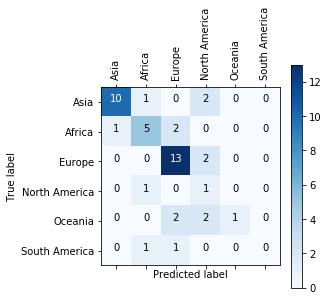

In [58]:
#Plotting the confusion matrix for this model
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cont_key,)
plt.show()

We can see from our results above that the model did really well in the training set, but worse in the testing set, although it is still fairly accurate. The areas that it performed poorly in were South America, Oceania, and North America. This is likely due to the fact that South America had only two countries in the testing set and 11 in the training set, making it hard for the model to predict something that occurs so infrequently. Additionally, we can see that Oceania did perfect in precision but poor in recall, and the opposite for North America. This shows that it overpredicted North America for everything that could be a North American or Oceanian country or that North America was hard to predict because there were only two North American countries in the testing set. That would explain the results for precision and recall for these two continents. 

Next, we try to run the boosting model again, but this time with less features, as maybe the model overfits too much on the training set, causing the testing set predictions to be poor. Below is our model on this new set of data. 

In [59]:
#create new dataset that has less features
df_reduced = df.drop(['coastline_km', 'PopDens', 'HealthExpend', 'AdultObesityRate', 'MaternalMortalityRate', 'GDP_PPP', 'PopGrowthRate'], axis=1)

In [60]:
#create new dataset that drops the classification variables from the dataset previously created
df_reduced1 = df_reduced.drop(['cont', 'name', 'contnum'], axis=1)

In [61]:
#break up data into train and test subsets
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_reduced1, df_reduced.cont, test_size=0.20, random_state=42)

In [62]:
#fit model to training data
gridsearch.fit(X_train2, y_train2)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 1000, 5000], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_micro', verbose=0)

In [63]:
#print the best parameters found from cross-validation and the results of the model for train and test subsets
print("Best Params: {}".format(gridsearch.best_params_))
print("\nClassification Report (TEST):")
print(classification_report(y_test2, gridsearch.predict(X_test2)))
print("\nClassification Report (TRAIN):")
print(classification_report(y_train2, gridsearch.predict(X_train2)))

Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}

Classification Report (TEST):
               precision    recall  f1-score   support

       Africa       0.91      0.77      0.83        13
         Asia       0.75      0.75      0.75         8
       Europe       0.82      0.93      0.87        15
North America       0.33      1.00      0.50         2
      Oceania       1.00      0.40      0.57         5
South America       1.00      0.50      0.67         2

  avg / total       0.84      0.78      0.78        45


Classification Report (TRAIN):
               precision    recall  f1-score   support

       Africa       1.00      1.00      1.00        42
         Asia       1.00      1.00      1.00        44
       Europe       1.00      1.00      1.00        33
North America       1.00      1.00      1.00        32
      Oceania       1.00      1.00      1.00        16
South America       1.00      1.00      1.00        11

  avg / total       1.00      1.0

Confusion matrix, without normalization
[[ 8  3  0  2  0  0]
 [ 1  6  1  0  0  0]
 [ 0  0 15  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  1  2  2  0]
 [ 0  1  0  0  0  1]]


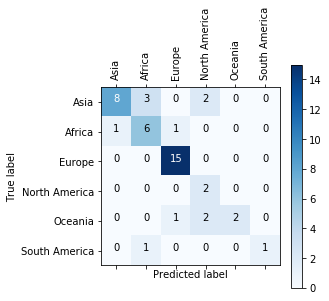

In [64]:
#Plotting the confusion matrix for this model
y_pred = clf.fit(X_train2, y_train2).predict(X_test2)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test2, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cont_key,)
plt.show()

We can see in our results above that it did perfect in the training set and fairly well in the testing set, outperforming the first model.

Next, let's try creating the model on a subset of the data (with the reduced features that performed the best) and then testing its predictions on the entire dataset. We conduct this test below.

In [65]:
#break up data into train and test subsets 
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_reduced1, df_reduced.cont, test_size=0.20, random_state=42)

In [66]:
#fit the model to the training data
gridsearch.fit(X_train2, y_train2)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [100, 1000, 5000], 'max_depth': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_micro', verbose=0)

In [67]:
#print the results of the model from running it on the entire dataset
print("\nClassification Report (TOTAL):")
print(classification_report(df.cont, gridsearch.predict(df_reduced1)))


Classification Report (TOTAL):
               precision    recall  f1-score   support

       Africa       0.98      0.95      0.96        55
         Asia       0.96      0.96      0.96        52
       Europe       0.94      0.98      0.96        48
North America       0.89      1.00      0.94        34
      Oceania       1.00      0.86      0.92        21
South America       1.00      0.92      0.96        13

  avg / total       0.96      0.96      0.96       223



Confusion matrix, without normalization
[[50  3  0  2  0  0]
 [ 1 50  1  0  0  0]
 [ 0  0 48  0  0  0]
 [ 0  0  0 34  0  0]
 [ 0  0  1  2 18  0]
 [ 0  1  0  0  0 12]]


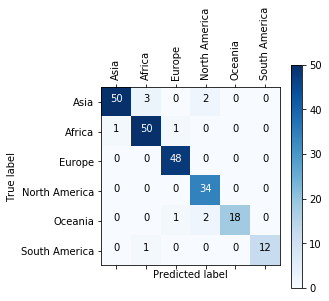

In [68]:
#Plotting the confusion matrix for this model
y_pred = clf.fit(X_train2, y_train2).predict(df_reduced1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(df_reduced.cont, y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cont_key,)
plt.show()

Great! We see that the model performs really well on the full data set, with an F1 score of .96.

## t-SNE

t-SNE is a visualization tool that compresses high-dimensional data into 2 dimensions through PCA. These first dimension is the axis that explains the most variance of any other axis and then the second component is the dimension orthogonal to the first. The purpose of doing t-SNE is to be able to view high dimensional data. The model tries to separate and cluster data points that belong to the same class.

In the code below, I reduce the dimensionality to 2 principal components and feed this compressed data into the t-SNE model to visualize it. The value of the perplexity parameter I chose was the one that did the best job of separating, clustering, and visualizing the data. We can see that the model is not great, but it does do a decent job of clumping the North American and Oceania countries. However, these points seem to be bunched together, likely due to the fact the model may have a hard time differentiating between the Oceania islands and the Caribbean and Virgin Islands that belong to North America. Africa is clustered pretty well in the middle of the graph. South America seems to be pretty spread out, which is to be expected because it is the continent with the least amount of countries. It's hard for a model to classify when there aren't a lot of observations to learn from. 

In [71]:
#create new dataset that contains all observations with no classification variables
df_total = df.drop(['cont', 'name', 'contnum'], axis=1)

In [84]:
#define pca function to compress data to 2 components and fit it to data
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_total)

In [85]:
#define t-SNE and its parameters and fit it to the compressed data
tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=2000, learning_rate=10)
tsne_results = tsne.fit_transform(df_pca)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 223 samples in 0.000s...
[t-SNE] Computed neighbors for 223 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 223 / 223
[t-SNE] Mean sigma: 245718027.161373
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.831837
[t-SNE] Error after 1450 iterations: 0.103503


In [86]:
#create dataframe with the results of t-SNE
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = df.cont

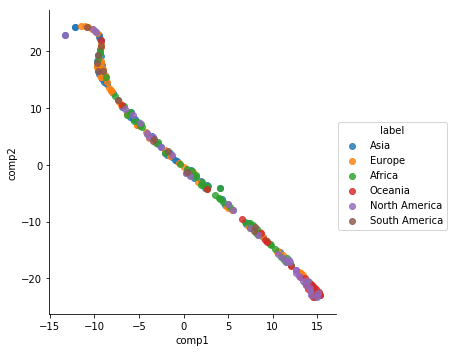

In [87]:
#create visualization of t-SNE
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

## Conclusion

To conclude, we see that our models did a fair job in classifying countries to their respective continents. The F1 scores show that the model performed fairly well. It would be interesting to do another run through these models but with more data for each country. The World Factbook provides more data on more variables that aren't compiled in the downloadable dataset. If we manually input these data into our dataset, perhaps the model would be able to classify even better with this added information. 

Our models show that given a set of demographic, geographic, and economic data for countries, we can accurately predict what continent each country belongs to, and gives us insight into trends, similarities, and differences between contries within and across continents. 